# Synopsis

#### Update 5: I think the symmetry and NFP bugs in `grid.py` are fixed.

#### Update 4: I replaced edu-vmec with the VMEC output in DESC/examples. This gave better matches. This is finished now.
* Compared to more equilibrium and the mercier quantities matched except for the few outlier points near rho=0 and rho=1. Hoping that's just VMEC being weird.
* Unit tests added.
* Mercier quantities added to `data_index`.
* [state of the NFP and symmetry bugs in grid class as of Aug 7](#Grid-bug-status-as-of-Aug-7).

#### Update 3: I think this implementation is correct. Can't find anything that would be wrong.
* Heliotron and dshape are near-exact matches to STELLOPT with symmetry off, close with symmetry on.
* Increasing the number of surfaces (rho resolution) on educational VMEC input from 256 to 1024 didn't change anything significantly.
* I had mentioned at the meeting that the DESC plots don't match edu-vmec's plots. I don't think that means much anymore. Previously all the curves (desc, STELLOPT, edu-vmec) disagreed, causing me confusion. I couldn't single out one of them as correct or incorrect. Now that STELLOPT and DESC agree, I think we can claim edu-vmec is doing something wrong.
* I think what took me longer than I thought with this was:
    - I was learning basics of DESC code as it was my first project in DESC.
    - The STELLOPT code really looks like they implement the magnetic well parameter from Landreman equation 3.2. So when my implementation didn't match that, I was scratching my head wondering why. Based on these results it looks like STELLOPT secretly implements equation 4.19.
    - Didn't know edu-vmec was giving bad results (I wonder if this is also true for rotational transform stuff).
    - I had to account for sym / NFP / single surface bugs in the grid class to fix d$\theta$ * d$\zeta$ stuff.

#### Update 2: works with arbitrary grids and computes magnetic well parameter over multiple flux surfaces simultaneously
Made use of the `surface_integrals` functionality I added while coding the new rotational transform function. The objective will still function in the same way as before if a single rho surface is given as input. However, computing magnetic well over multiple flux surfaces at once offers at least two benefits. It
* Simplifies end user code. They don't have to create routines and loop through things.
* Increases performance. What used to take hours now runs in < 3 minutes.
* Please see [a bug in the grid class](#Surface-element-computation-problem-and-solution). The solution to this bug for grids with a single rho surface is simple. If the functions I added to `compute.utils` are used then the developer/user doesn't have to worry about it. However, for multiple rho surface grids, the fix isn't as simple. Until that fix is implemented, if the user wants magnetic well computed on a grid with multiple values of rho, they should provide a grid with `NFP=1` and `sym=False`.

#### Update 1: alternative version of magnetic well in Landreman paper added
This one matches VMEC.

## the Good
The magnetic well parameter computed by DESC matches VMEC.

The volume computation is now correct. The solution to the bug in the `grid.py` class works, which was necessary to correct volume and dv/d$\rho$. An [explanation to the solution is given here](#Surface-element-computation-problem-and-solution). Might be useful in case we have run into this bug somewhere else in the code.

All the [plots](#Plots) of DESC's intermediate quantities are consistent with each other. For every point below, I have confirmed their validity with code tests and math where applicable. These intermediate plots are no longer plotted in this notebook, but can be seen in the GitHub commit history.

* The volume of the torus is exactly quadratic with $\rho$. The derivative of the volume enclosed by the flux surface is exactly linear. For the other stellarators, the volume and derivative are approximately quadratic and linear, respectively. The derivative computations also flatten when the volume curves linearize, and the opposite holds as well. All this matches our expectation that volume ~ $\rho$<sup>2</sup>.
* The volume enclosed by the $\rho$=1 surface matches the volume of the stellarator as computed by `data["V"]` on a grid with a sequence of $\rho$ values.
* The derivative of the thermal pressure average is always negative. This is good since our notion that the well parameter being positive implies stability is only valid when thermal pressure decreases away from the magnetic axis ($\rho$=0). Otherwise negative well parameters would imply stability.
* The derivative of the thermal pressure average looks very similar for stellarators with similar pressure profile inputs.
* Confidence in the new more complicated flux surface average
   - We now properly differentiate under the flux surface average operation. Pushing a volume derivative into a flux surface average requires more care than simply differentiating under the integral. We want to do this in the first place to take advantage of automatic differentiation of `B_r` and `p_r`.
   - Have shown the implementation has the desired additive homomorphism property; meaning average(a + b) = average(a) + average(b). Sanity check for correctness.
   - Confirmed `jnp.mean(f) / jnp.mean(`$\sqrt{g}$ `)`  always = `jnp.sum(dtdz * f) /` dv/d$\rho$ . Helps confirm dv/d$\rho$ is correct among other things.
   - Proved that this new flux surface average is an identity operation for the average of any quantity constant over the surface.
* The thermal pressure is a flux surface function; it is constant on a surface of constant rho. Therefore, the average of thermal pressure over a flux surface should be an identity operation. This is reflected in the code. Also, we take advantage of the homomorphism discussed above to avoid an unnecessary flux surface average operation.
* The derivative of the magnetic pressure average is positive (negative) precisely when B<sup>2</sup> average is increasing (decreasing). We should expect this since magnetic pressure ~ B<sup>2</sup>, and its average over a surface should likely share that relation.
* No jacobian sign errors. FYI: we always want them to be positive here.
* The volume derivative is not necessary for the magnetic well parameter for Landreman eq. 3.2. Replacing the flux surface label of volume with $\rho$ in that magnetic well formula gives the same result up to a scale factor.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from netCDF4 import Dataset
import pickle
import desc.io
from desc.vmec import VMECIO

from desc.equilibrium import Equilibrium
from desc.grid import LinearGrid, QuadratureGrid
from desc.objectives import (
    MercierStability,
    MercierShear,
    MercierCurr,
    MercierWell,
    MercierGeod,
    AltMagneticWell,
)

DESC version 0.5.1+118.g71ace73.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 7.73 GB available memory


In [2]:
class MercierStabilityVisual:

    plot_list = ("DMerc", "DShear", "DCurr", "DWell", "DGeod", "AltWell")

    def __init__(
        self,
        name,
        eq=None,
        use_pickle=False,
        rho=np.linspace(1 / 64, 1, 64),
    ):
        """
        Make a MercierStabilityVisual from either the provided equilibrium
        or the final equilibrium loaded from output.h5.

        Parameters
        ----------
        name : str
            Name of the equilibrium.
        eq : Equilibrium
            The equilibrium.
        use_pickle : bool
            True to use values computed from a previous run stored in pickle file; False to recompute.
        rho : ndarray
            The flux surface values to compute the magnetic well on.
        """
        self.name = name
        if eq is None:
            eq = desc.io.load(load_from="examples/DESC/" + name + "_output.h5")[-1]
        self.eq = eq

        if use_pickle:
            with open(name + " DESC mercier.pkl", "rb") as file:
                self.st = pickle.load(file)
            self.rho = self.st["DESC " + MercierStabilityVisual.plot_list[0]][0]
            self.has_values = True
        else:
            self.st = dict()  # values are tuples of (x[i], y[i]) of plot data
            try:
                f = Dataset("examples/VMEC/wout_" + name + ".nc")
                rho = np.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
                for q in MercierStabilityVisual.plot_list:
                    if q in f.variables:
                        self.st["VMEC " + q] = rho, np.asarray(f.variables[q])
                f.close()
            except FileNotFoundError:
                pass

            self.rho = rho
            self.has_values = False

    def save(self):
        """Save computed values to pickle file."""
        with open(self.name + " DESC mercier.pkl", "wb") as file:
            pickle.dump(self.st, file)

    def _compute_mercier(self, grid):
        DMerc = MercierStability(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        DShear = MercierShear(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        DCurr = MercierCurr(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        DWell = MercierWell(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        DGeod = MercierGeod(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        AltWell = AltMagneticWell(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        return DMerc, DShear, DCurr, DWell, DGeod, AltWell

    def compute_plot(self, quad_grid=False):
        """Compute and cache Mercier quantities in the plot_list.

        Parameters
        ----------
        quad_grid : bool
            True to use a quadrature grid for the computations.
            False to use linear grid.
        """
        if self.has_values:
            return

        if quad_grid:
            grid = QuadratureGrid(
                L=self.eq.L_grid,
                M=self.eq.M_grid,
                N=self.eq.N_grid,
                NFP=self.eq.sym,
            )
            self.rho = grid.nodes[grid.unique_rho_indices, 0]
        else:
            grid = LinearGrid(
                M=self.eq.M_grid,
                N=self.eq.N_grid,
                NFP=self.eq.NFP,
                sym=self.eq.sym,
                rho=self.rho,
            )
        keys = ["DESC " + key for key in MercierStabilityVisual.plot_list]
        for key, val in zip(keys, self._compute_mercier(grid)):
            self.st[key] = self.rho, val

        self.has_values = True

    def plot(self, dpi=150):
        """Plot all computed quantities and compare surfaces to VMEC."""
        try:
            VMECIO.plot_vmec_comparison(
                equil=self.eq,
                vmec_data="examples/VMEC/wout_" + self.name + ".nc",
            )
        except FileNotFoundError:
            pass

        fig, ax = plt.subplots(
            nrows=3,
            ncols=2,
            figsize=(15, 15),
            dpi=dpi,
        )
        ax = ax.flatten()

        i = 0
        for key in MercierStabilityVisual.plot_list:
            desc_key = "DESC " + key
            vmec_key = "VMEC " + key
            symlog = False
            ax[i].axhline(color="tab:purple")

            x, y = self.st[desc_key]
            symlog |= np.any(y <= 0)
            ax[i].plot(x, y, label=desc_key)
            ax[i].scatter(x, y, s=9)
            if vmec_key in self.st:
                x2, y2 = self.st[vmec_key]
                symlog |= np.any(y2 < 0)
                ax[i].plot(x2, y2, label=vmec_key)
                ax[i].scatter(x2, y2, s=3)
            ax[i].set(
                yscale="symlog" if symlog else "log",
                xlabel=r"$\rho$",
                ylabel=MercierStabilityVisual.plot_list[i],
                title=self.name,
                facecolor="white",
            )
            ax[i].grid()
            ax[i].legend(fontsize="xx-small")
            i += 1
        fig.tight_layout()

    def plot_magnetic_wells(self, dpi=150):
        """Plots the magnetic wells together on the same scale."""
        fig, ax = plt.subplots(dpi=dpi)
        ax.axhline(color="tab:purple")

        symlog = False
        if (key := "VMEC DWell") in self.st:
            rho, well = self.st[key]
            symlog |= np.any(well < 0)
            ax.plot(rho, well, label="VMEC")
            ax.scatter(rho, well, s=9)
        rho, well = self.st["DESC DWell"]
        symlog |= np.any(well <= 0)
        ax.plot(rho, well, label="DESC, M. Landreman eq. 4.19")
        ax.scatter(rho, well, s=3)
        rho, well = self.st["DESC AltWell"]
        symlog |= np.any(well <= 0)
        ax.plot(rho, well, label="DESC, M. Landreman eq. 3.2")
        ax.scatter(rho, well, s=3)

        ax.set(
            yscale="symlog" if symlog else "log",
            xlabel=r"$\rho$",
            ylabel="magnetic well",
            title=self.name,
            facecolor="white",
        )
        ax.grid()
        fig.legend(fontsize="xx-small")

In [3]:
torus = MercierStabilityVisual("torus", Equilibrium())
dshape = MercierStabilityVisual("DSHAPE")
heliotron = MercierStabilityVisual("HELIOTRON")
solovev = MercierStabilityVisual("SOLOVEV")
estell = MercierStabilityVisual("ESTELL")
wistell = MercierStabilityVisual("WISTELL-A")
stellarators = (torus, dshape, heliotron, solovev, estell, wistell)

/home/kaya/Documents/edu/pton/plasma/DESC/desc/configuration.py:344: UserWarning: Must specify either iota or current. Using default profile of iota=0.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


# Plots

Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms
Precomputing transforms


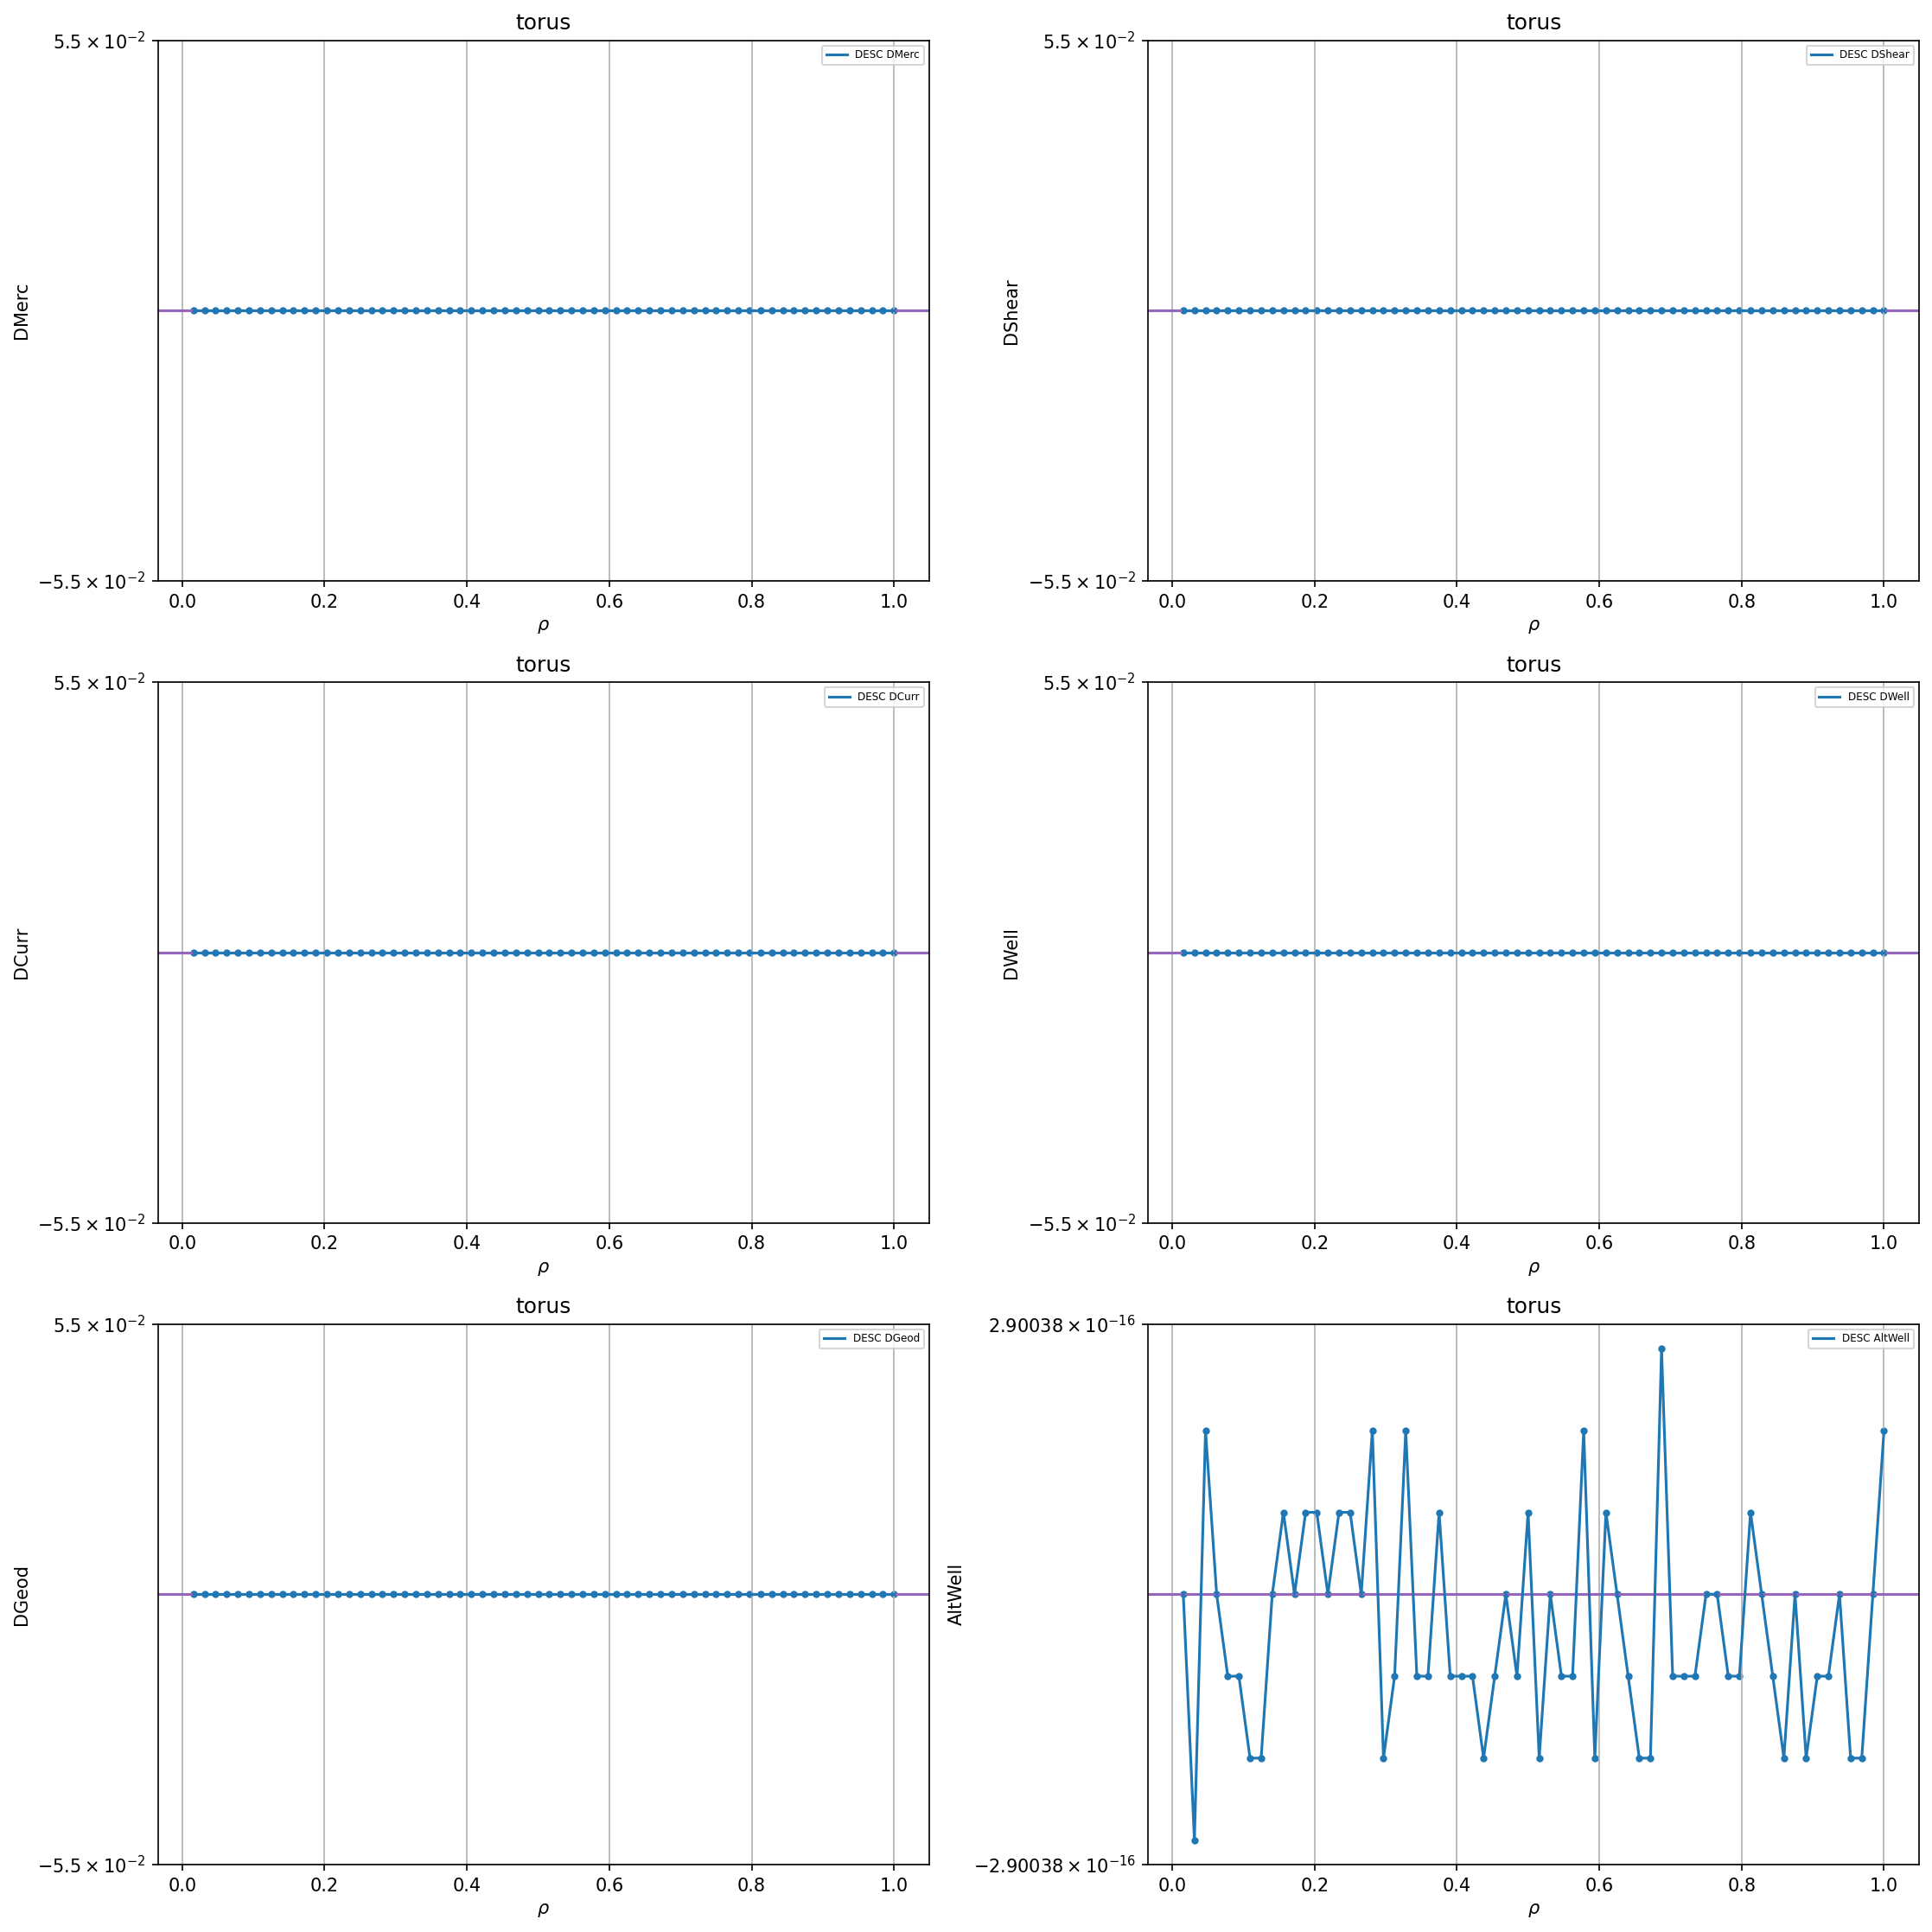

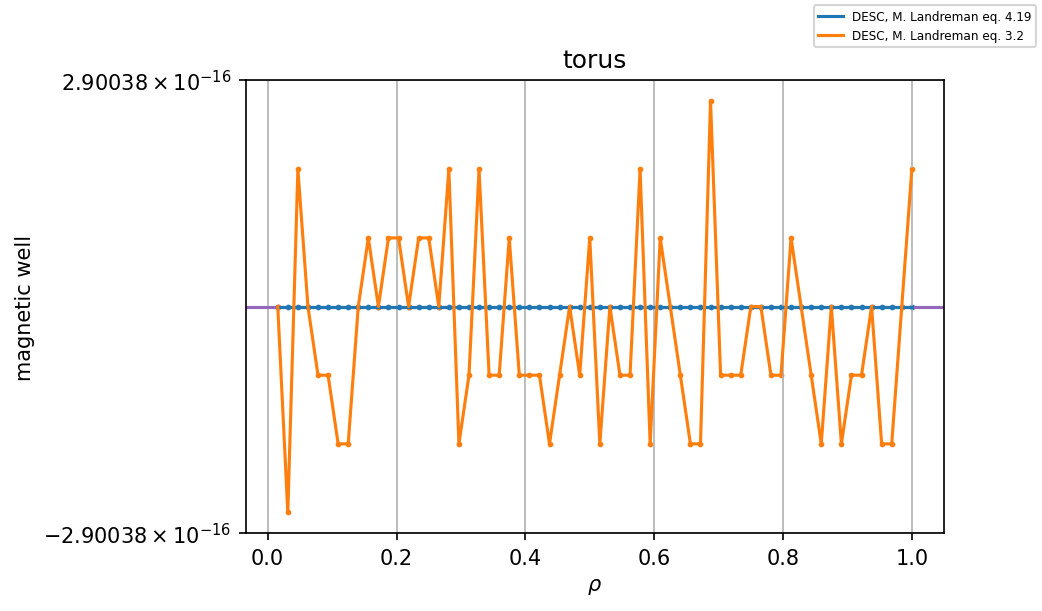

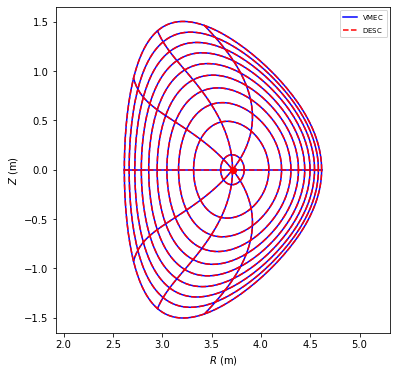

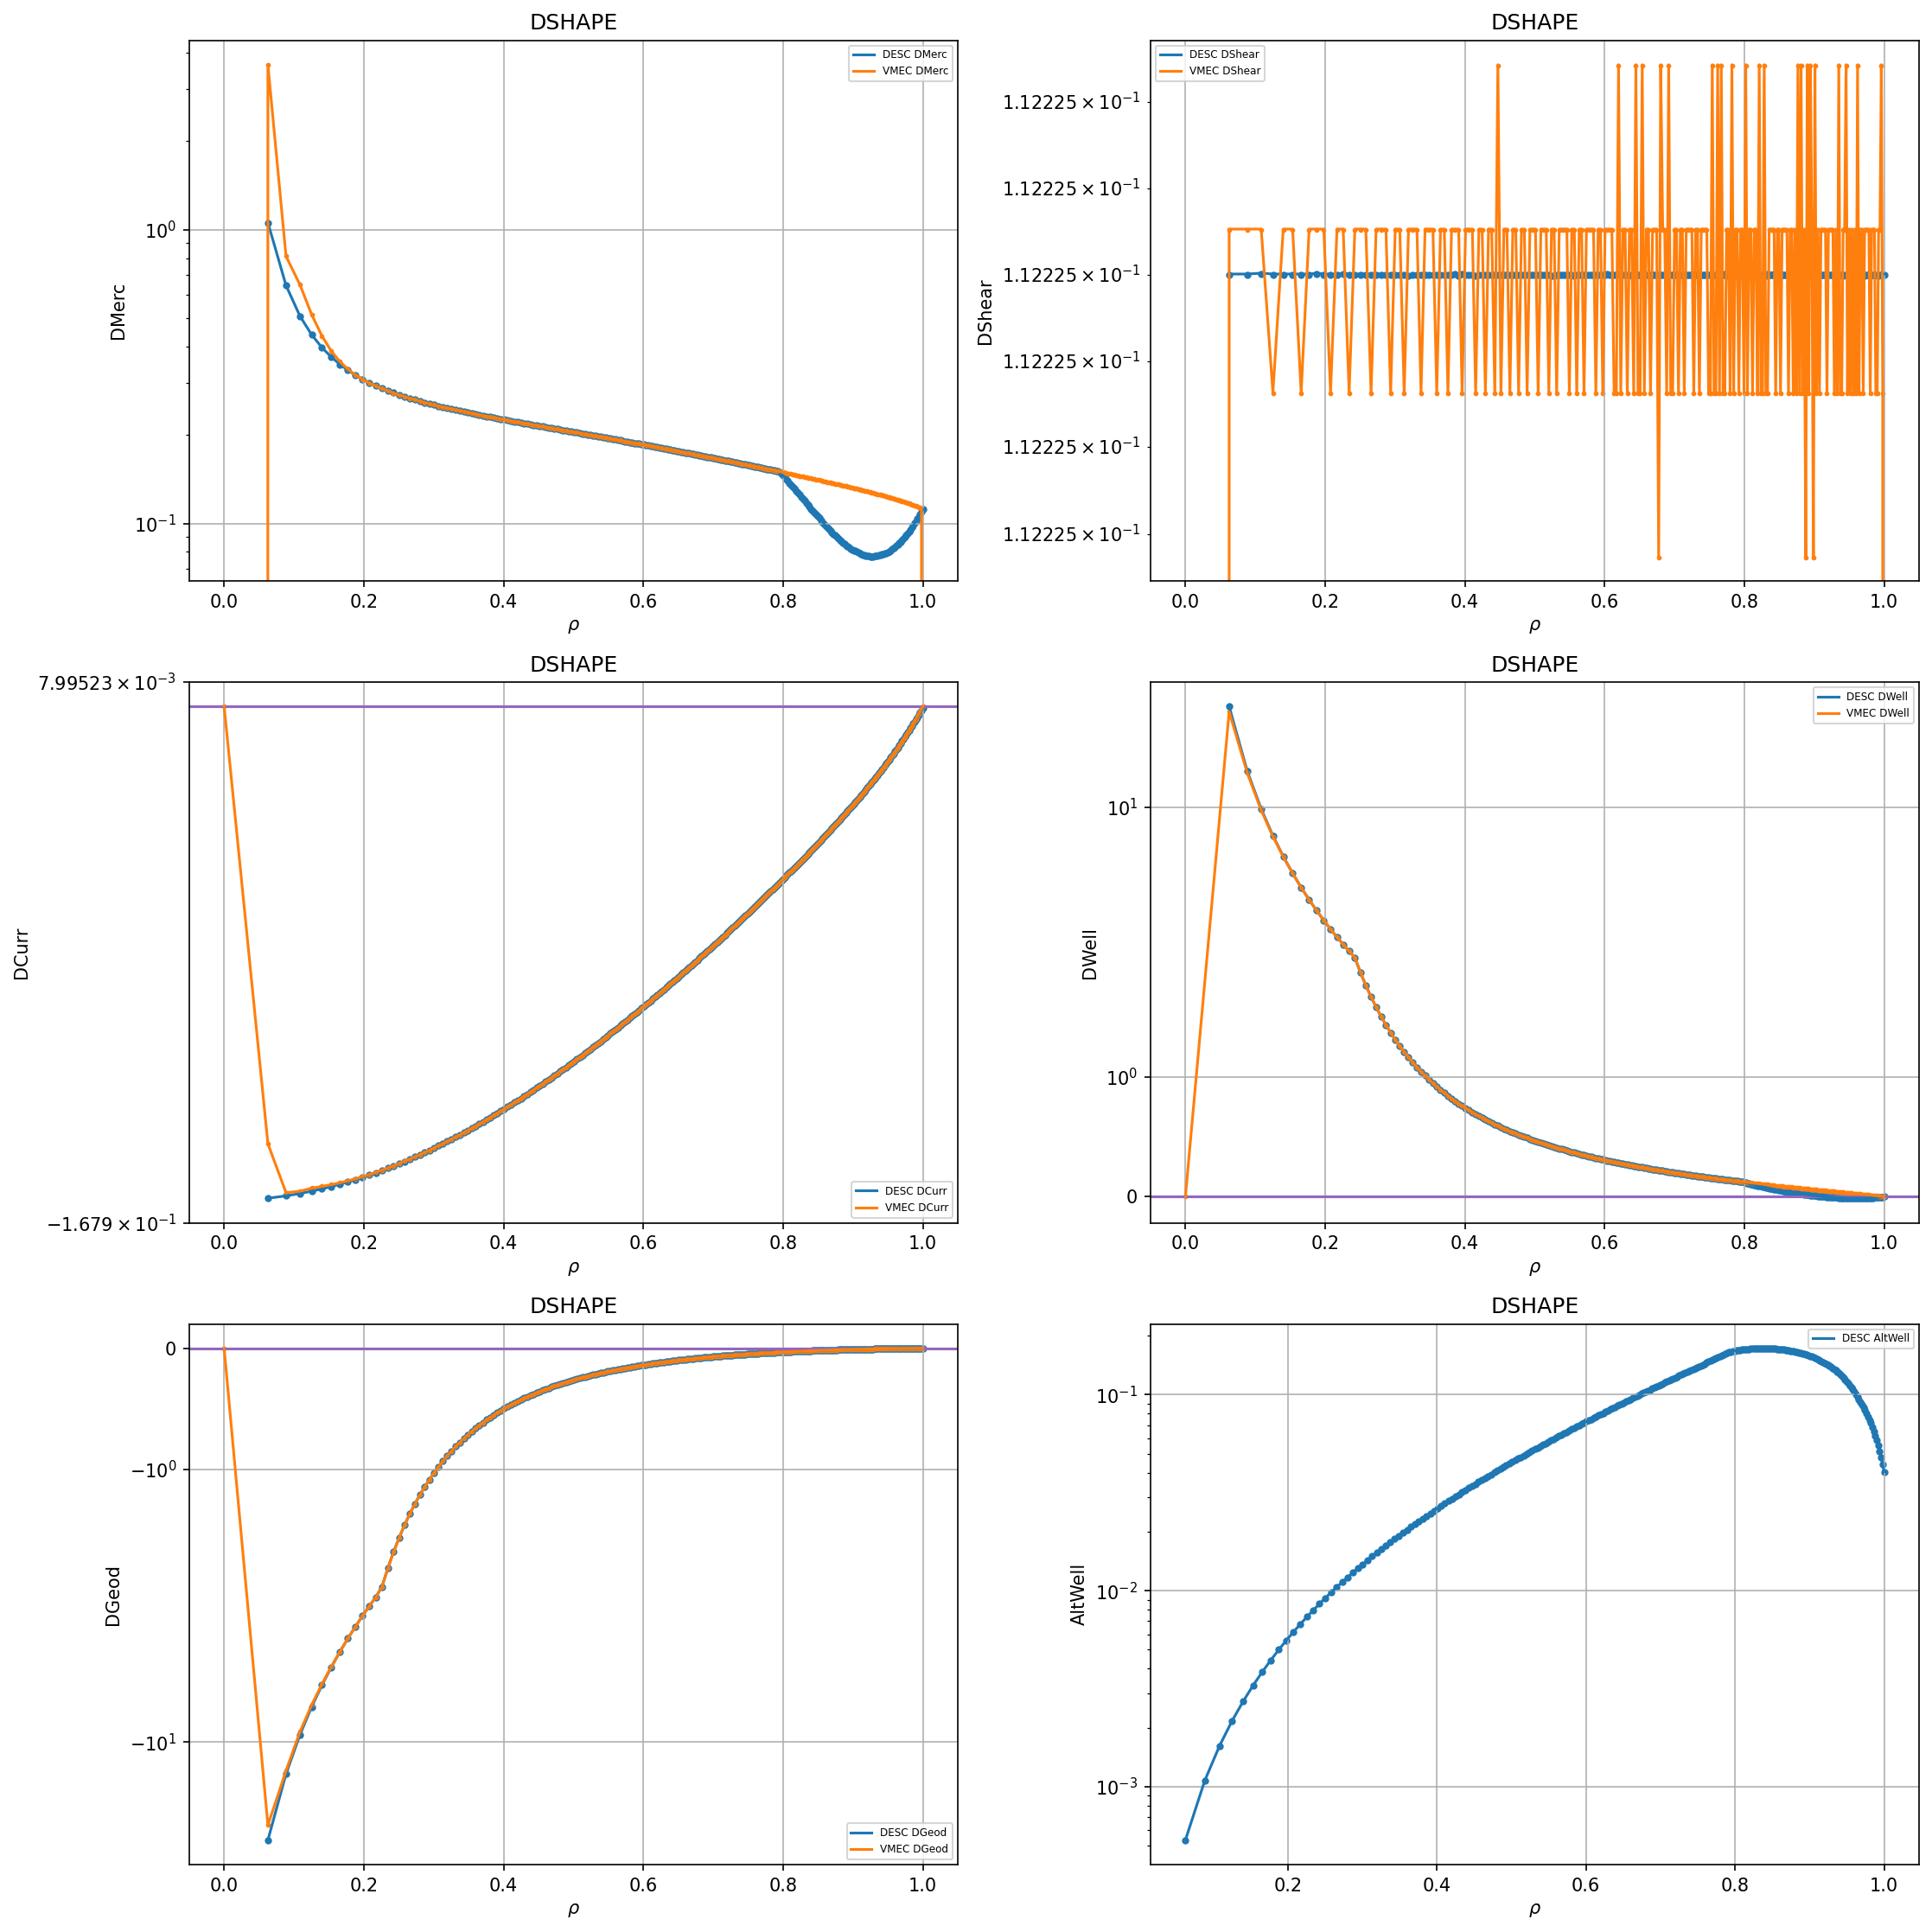

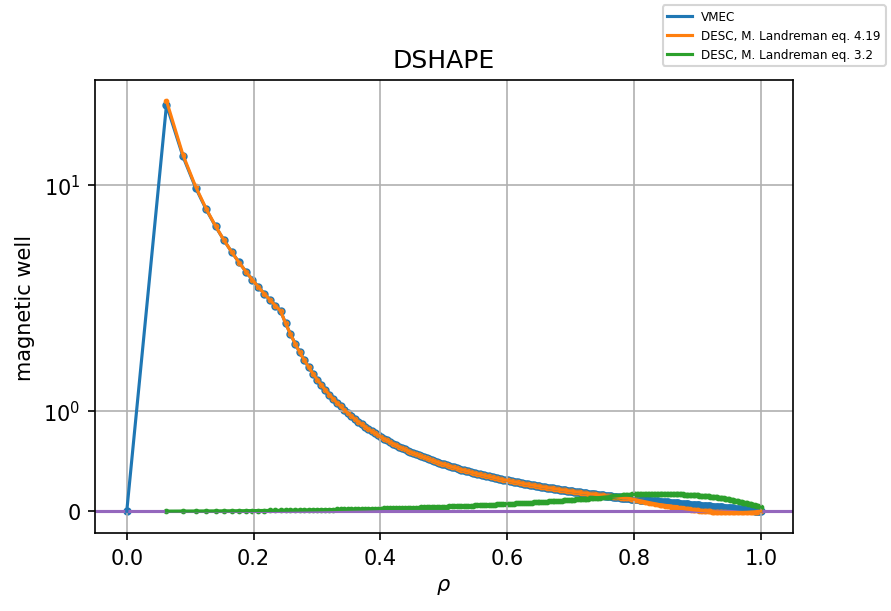

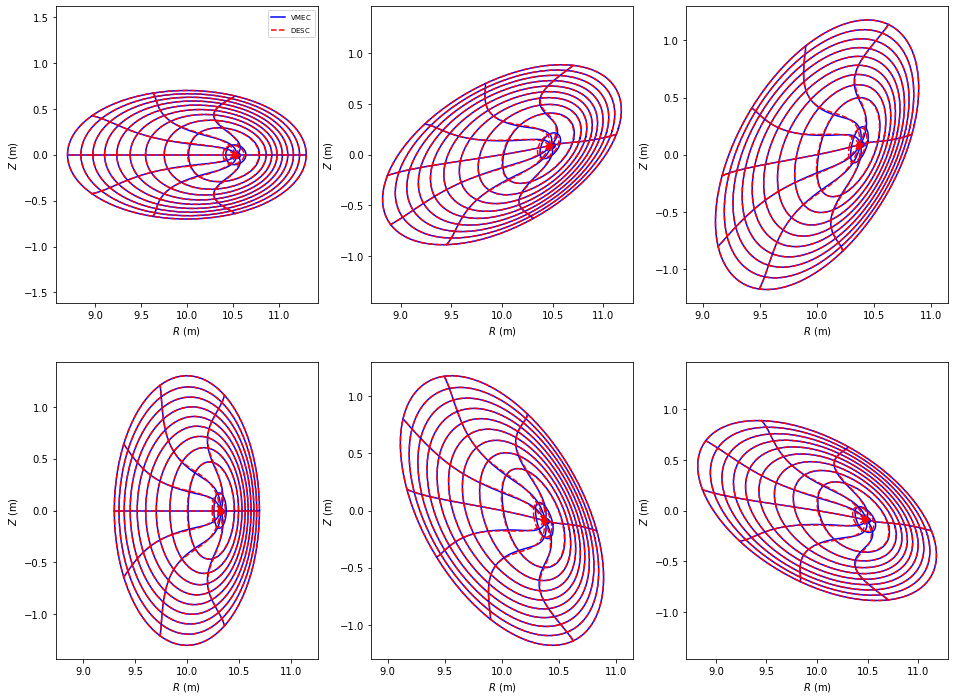

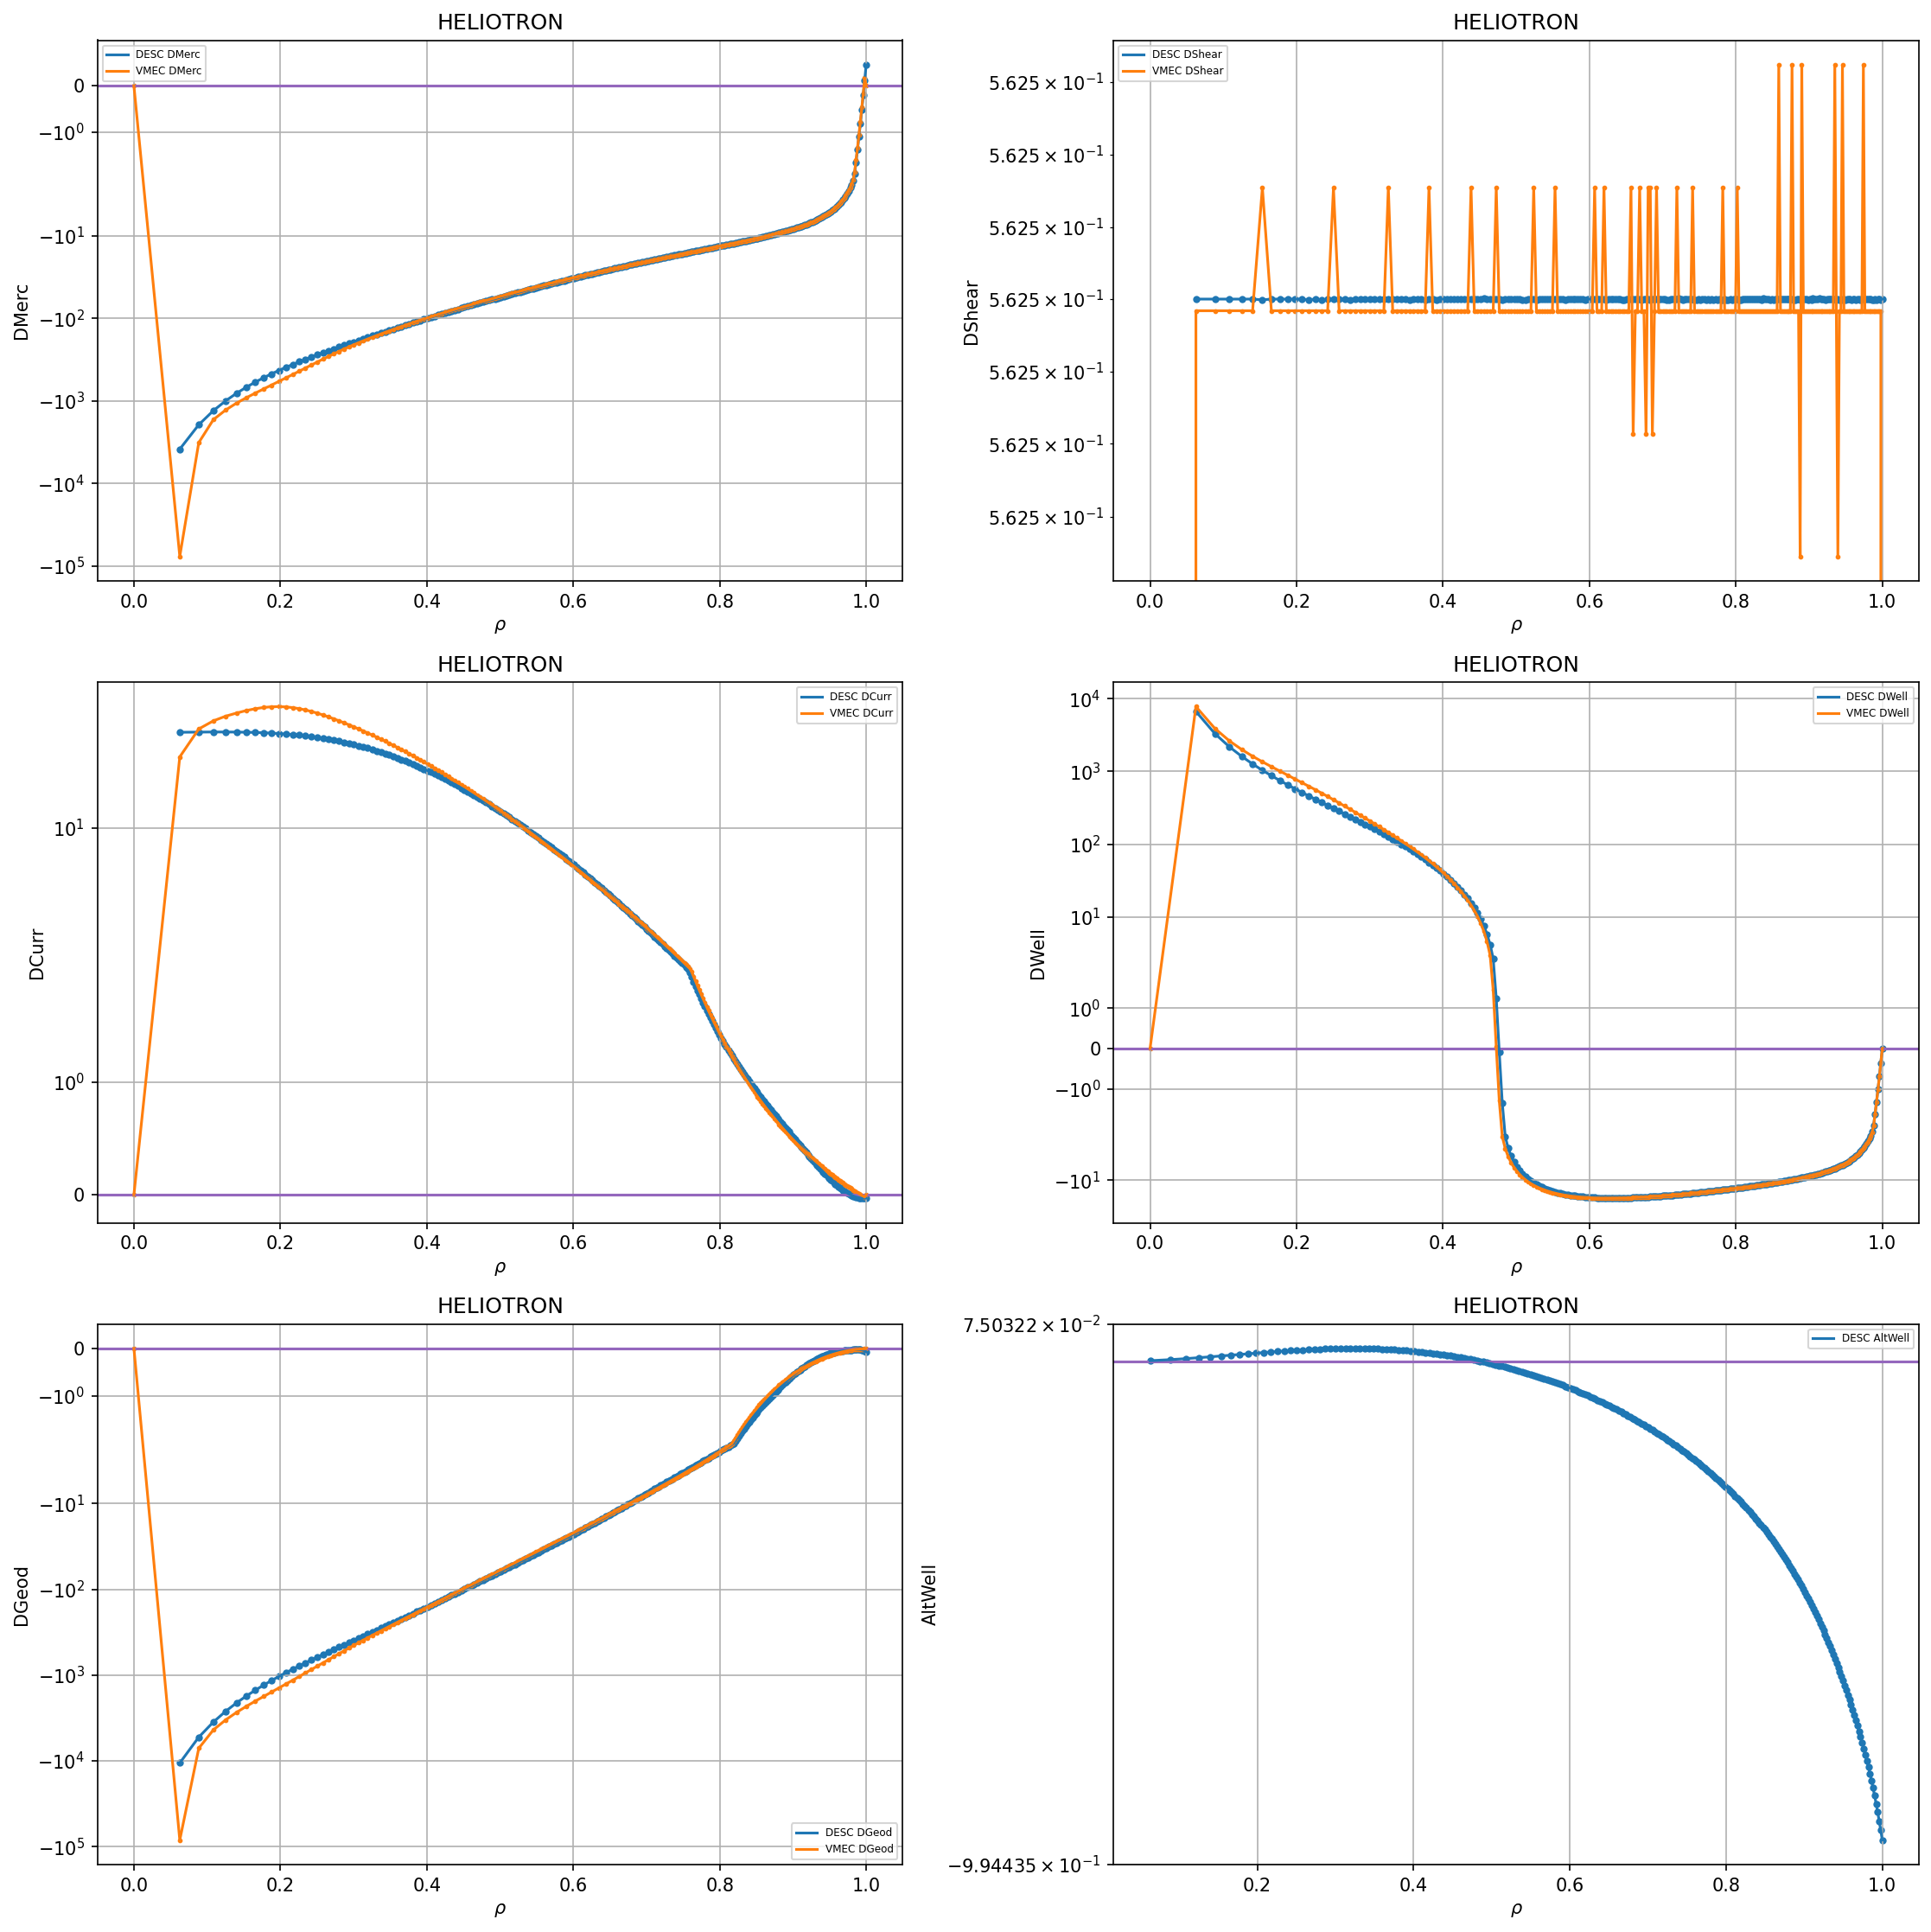

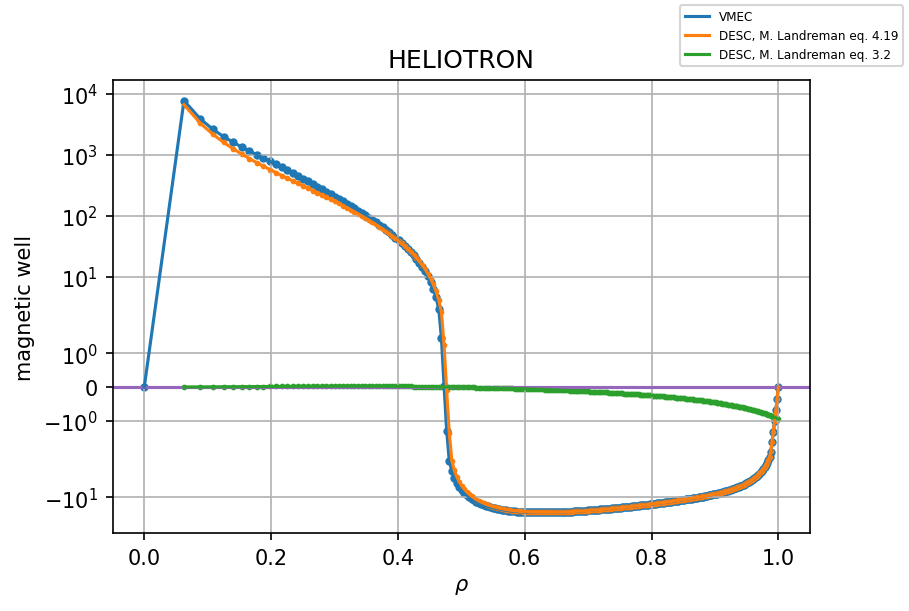

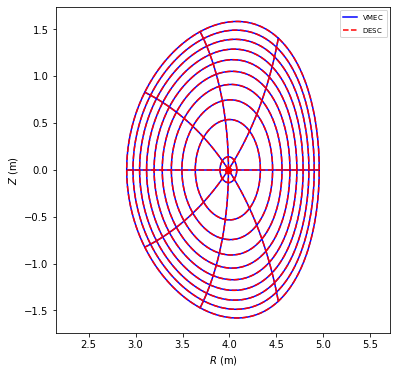

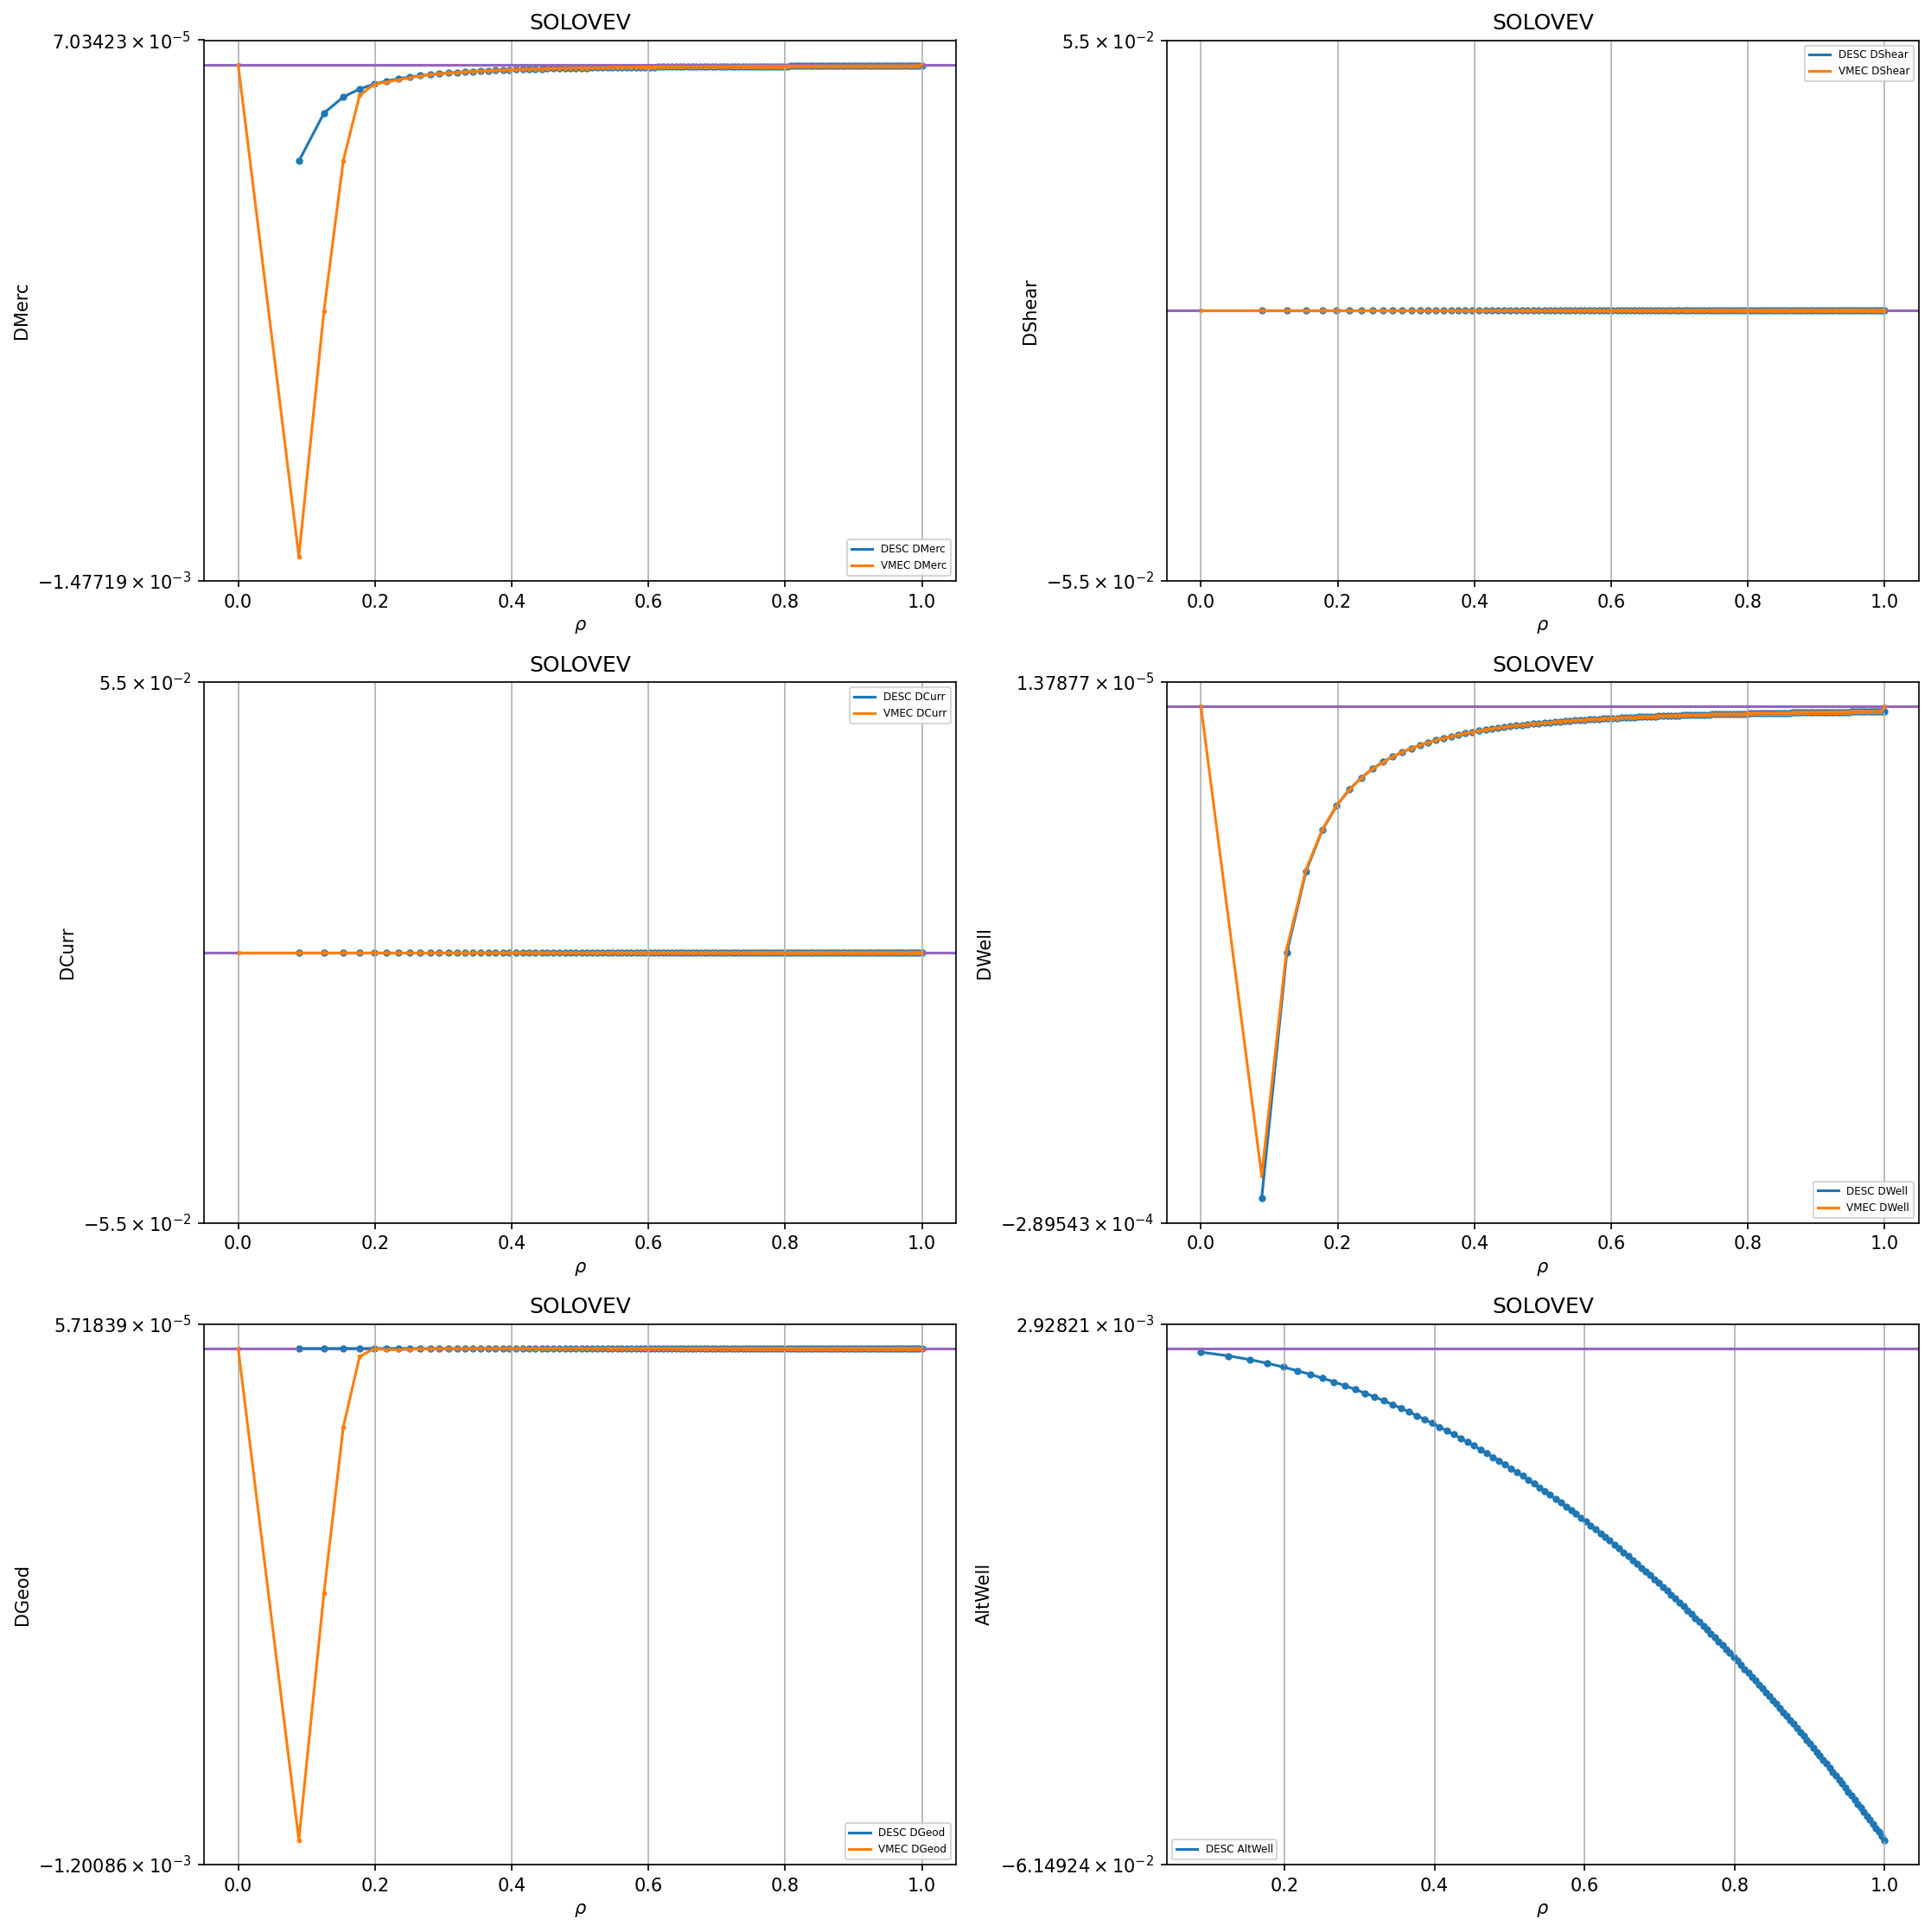

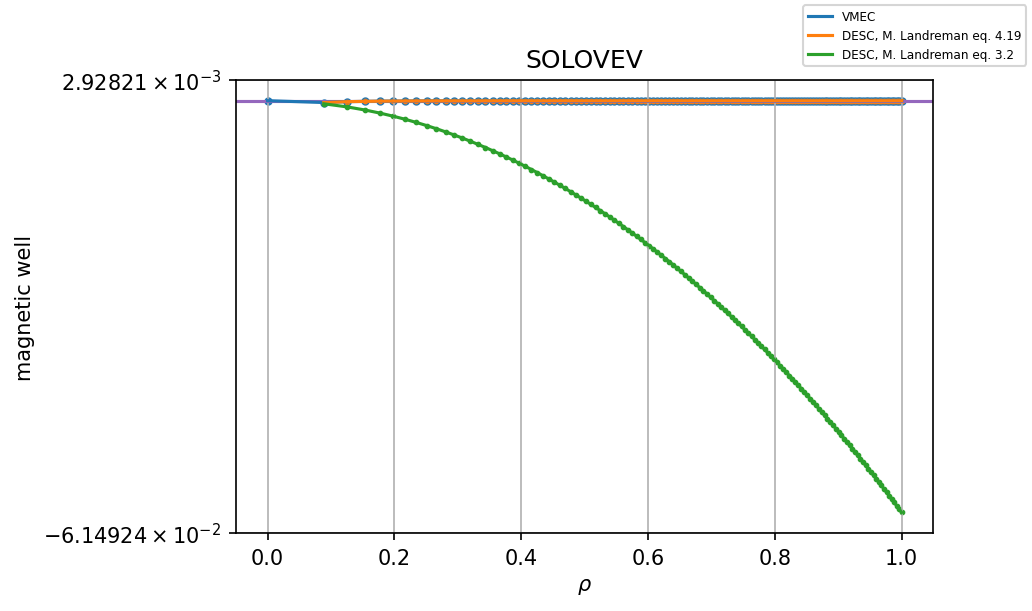

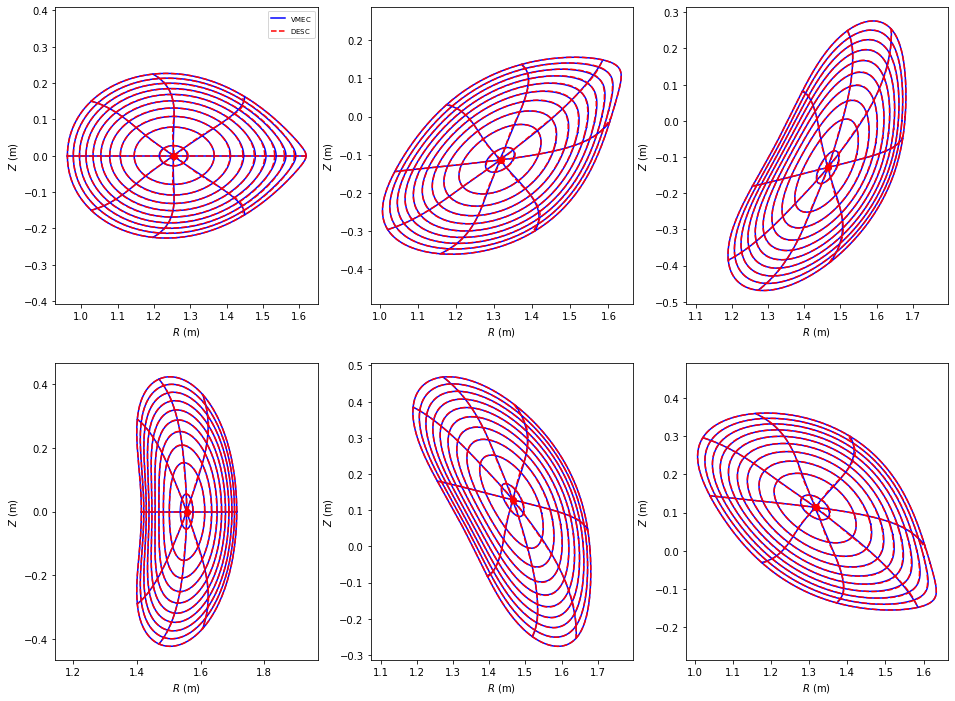

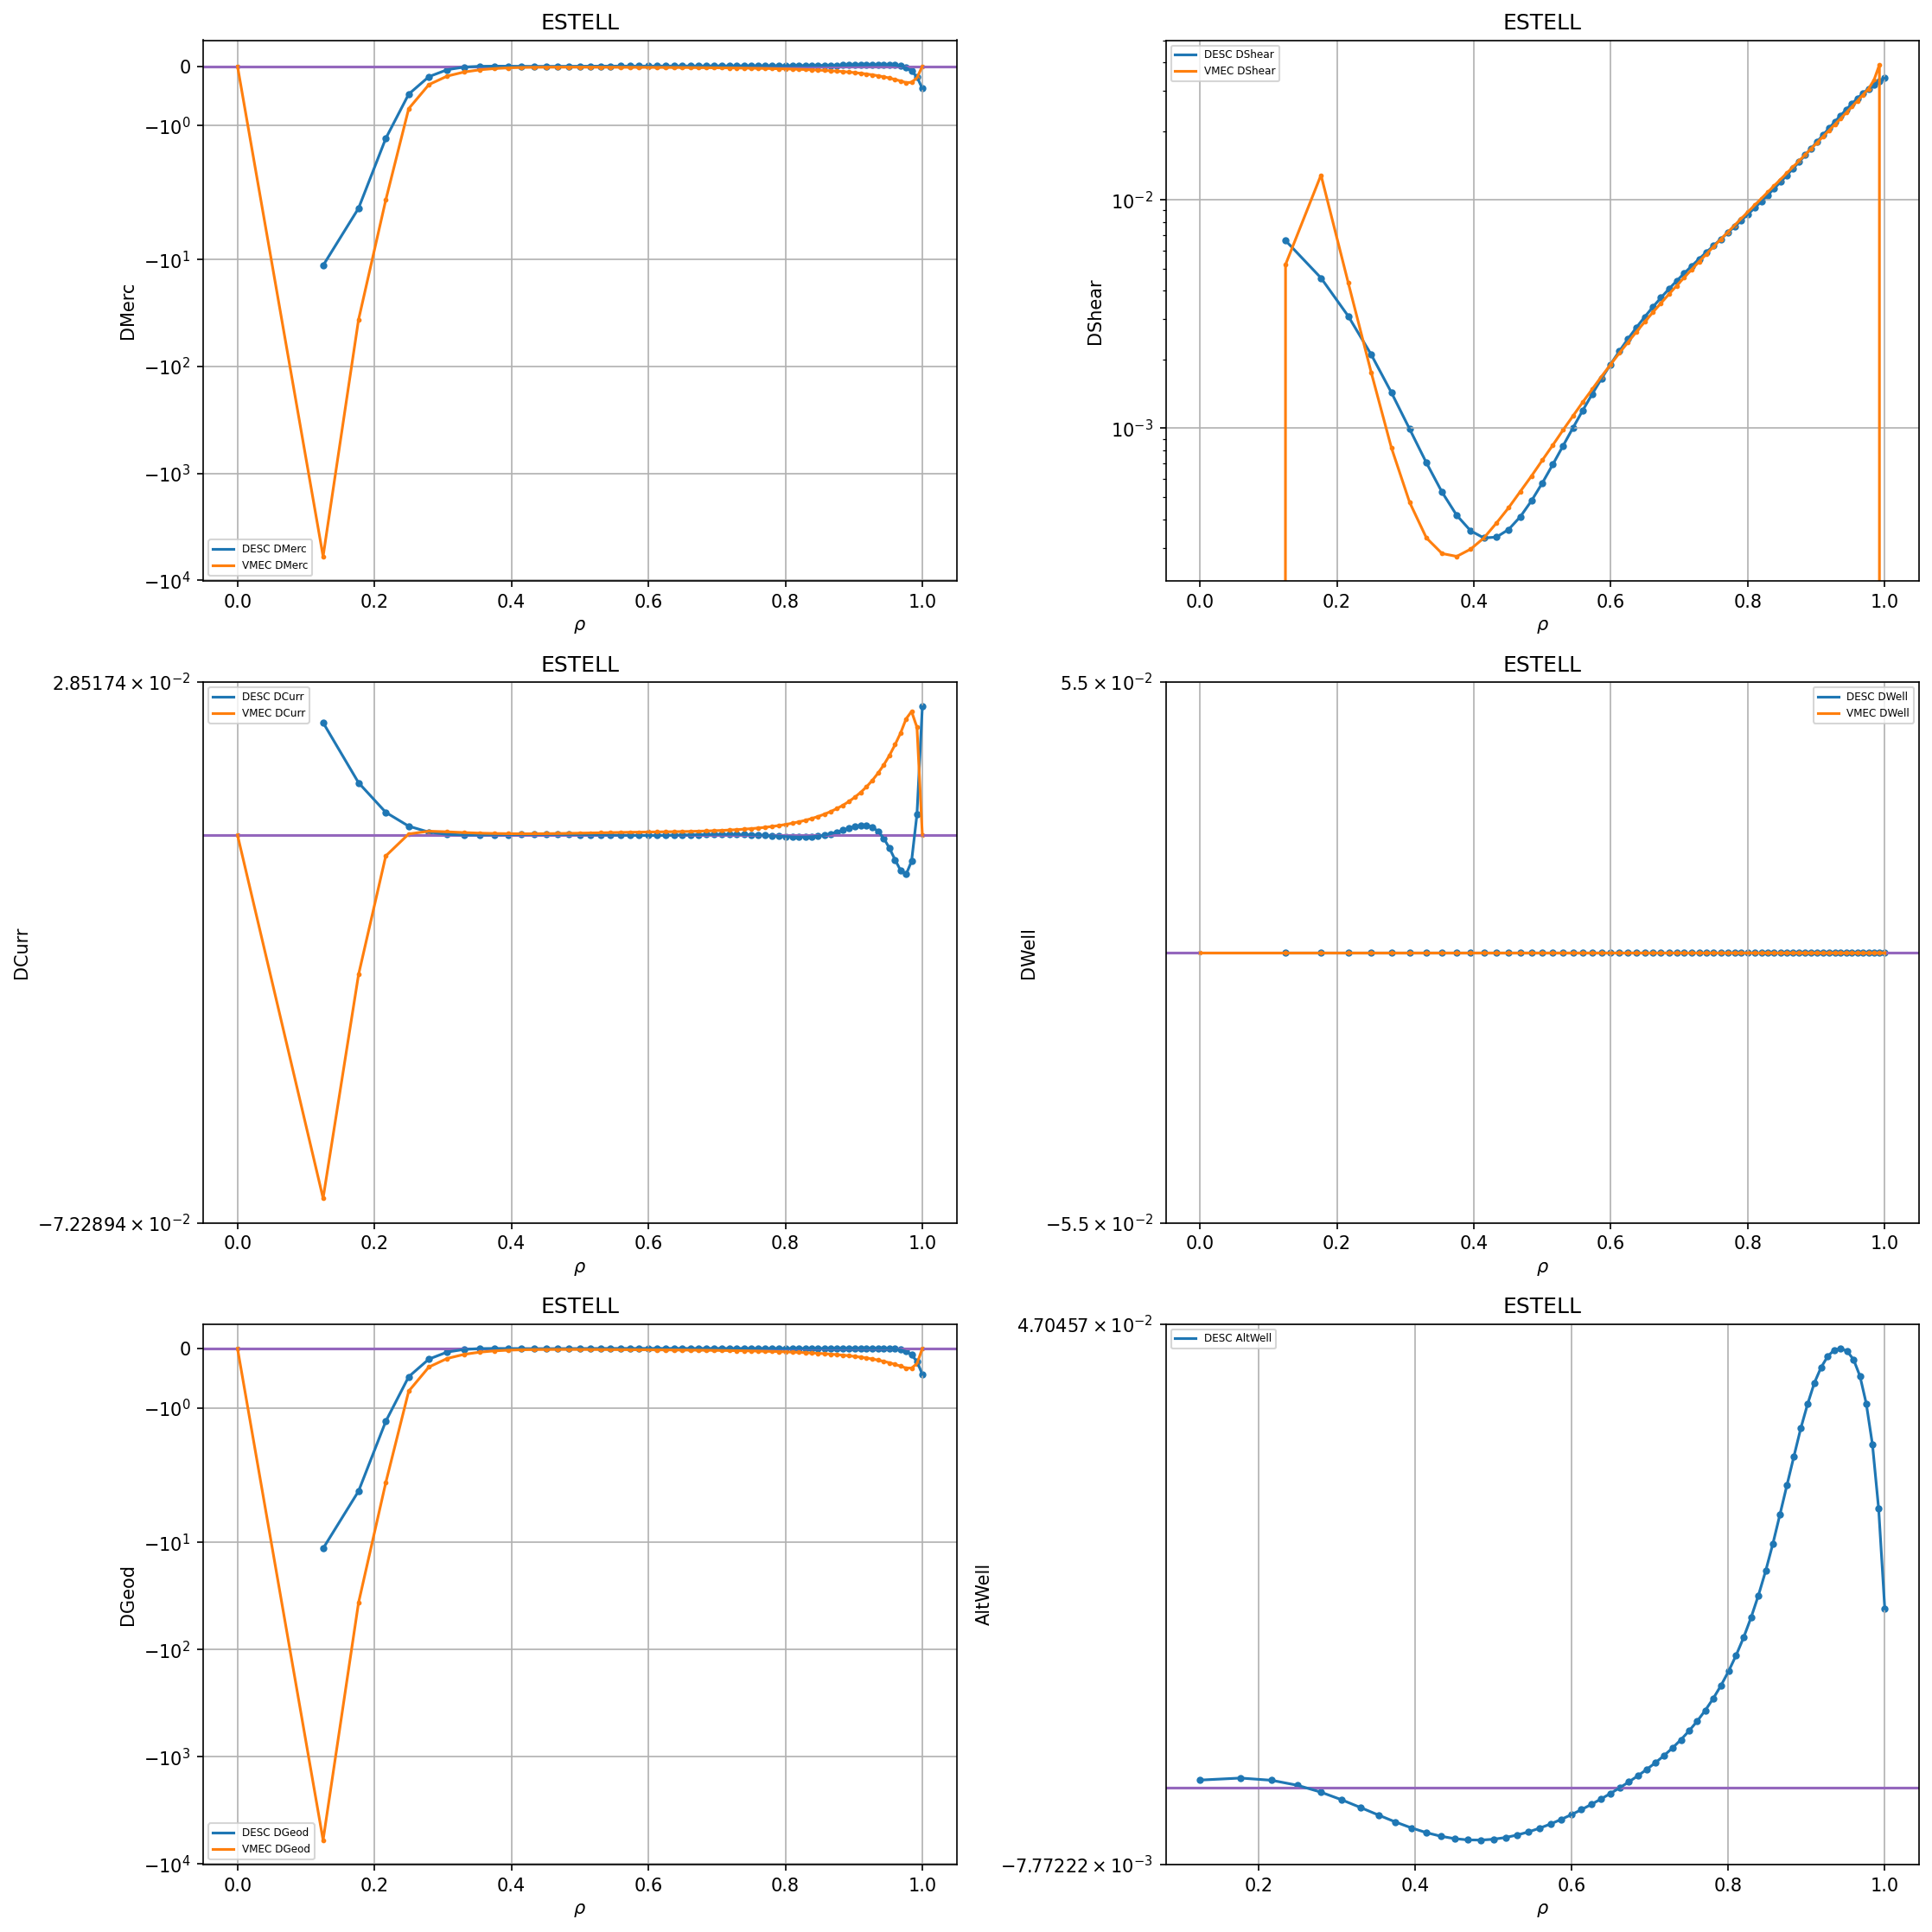

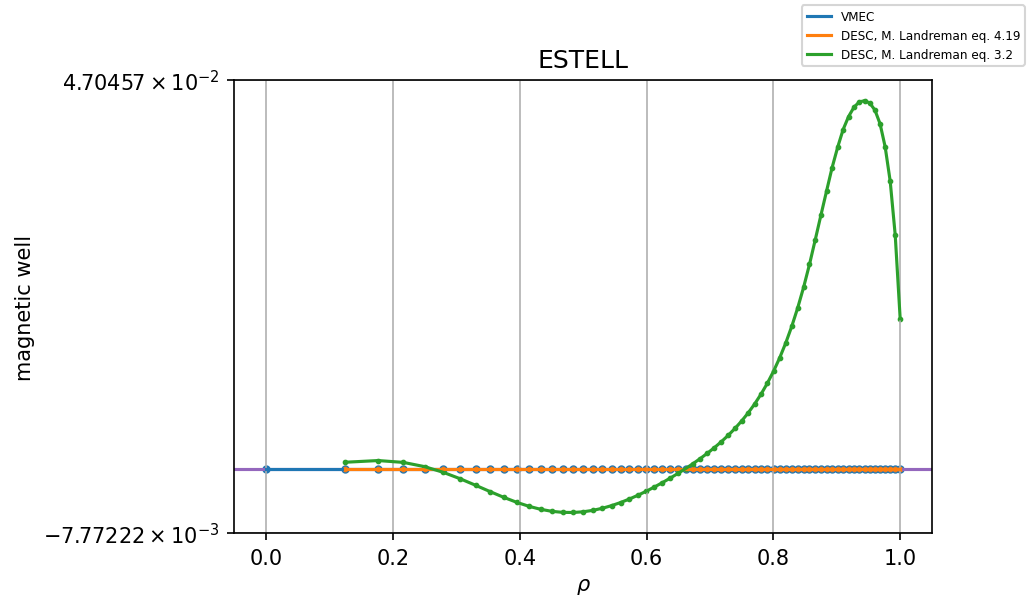

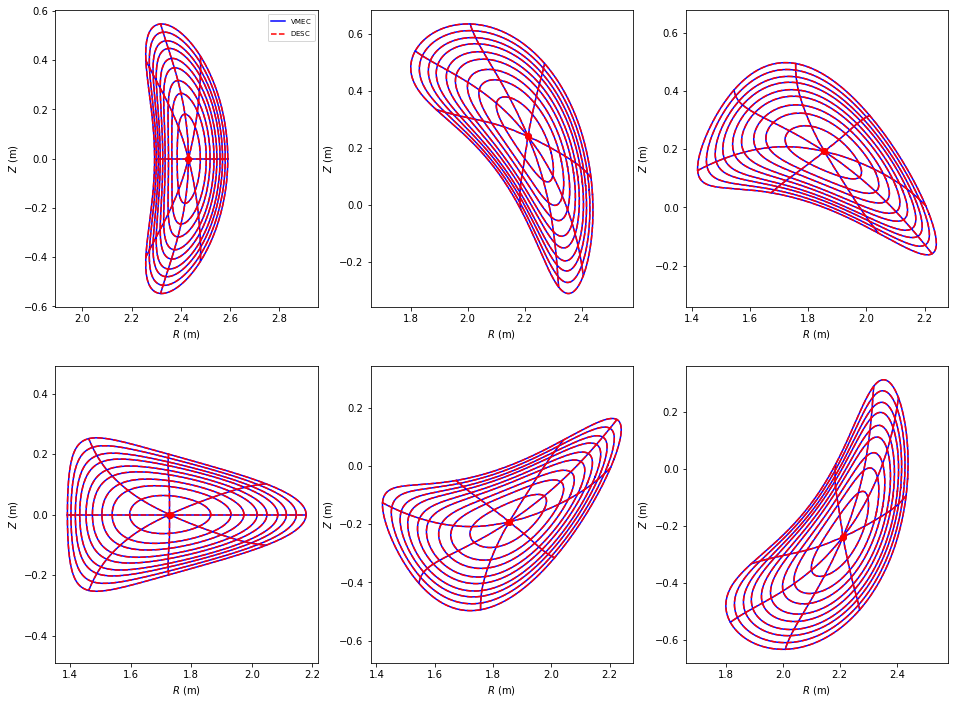

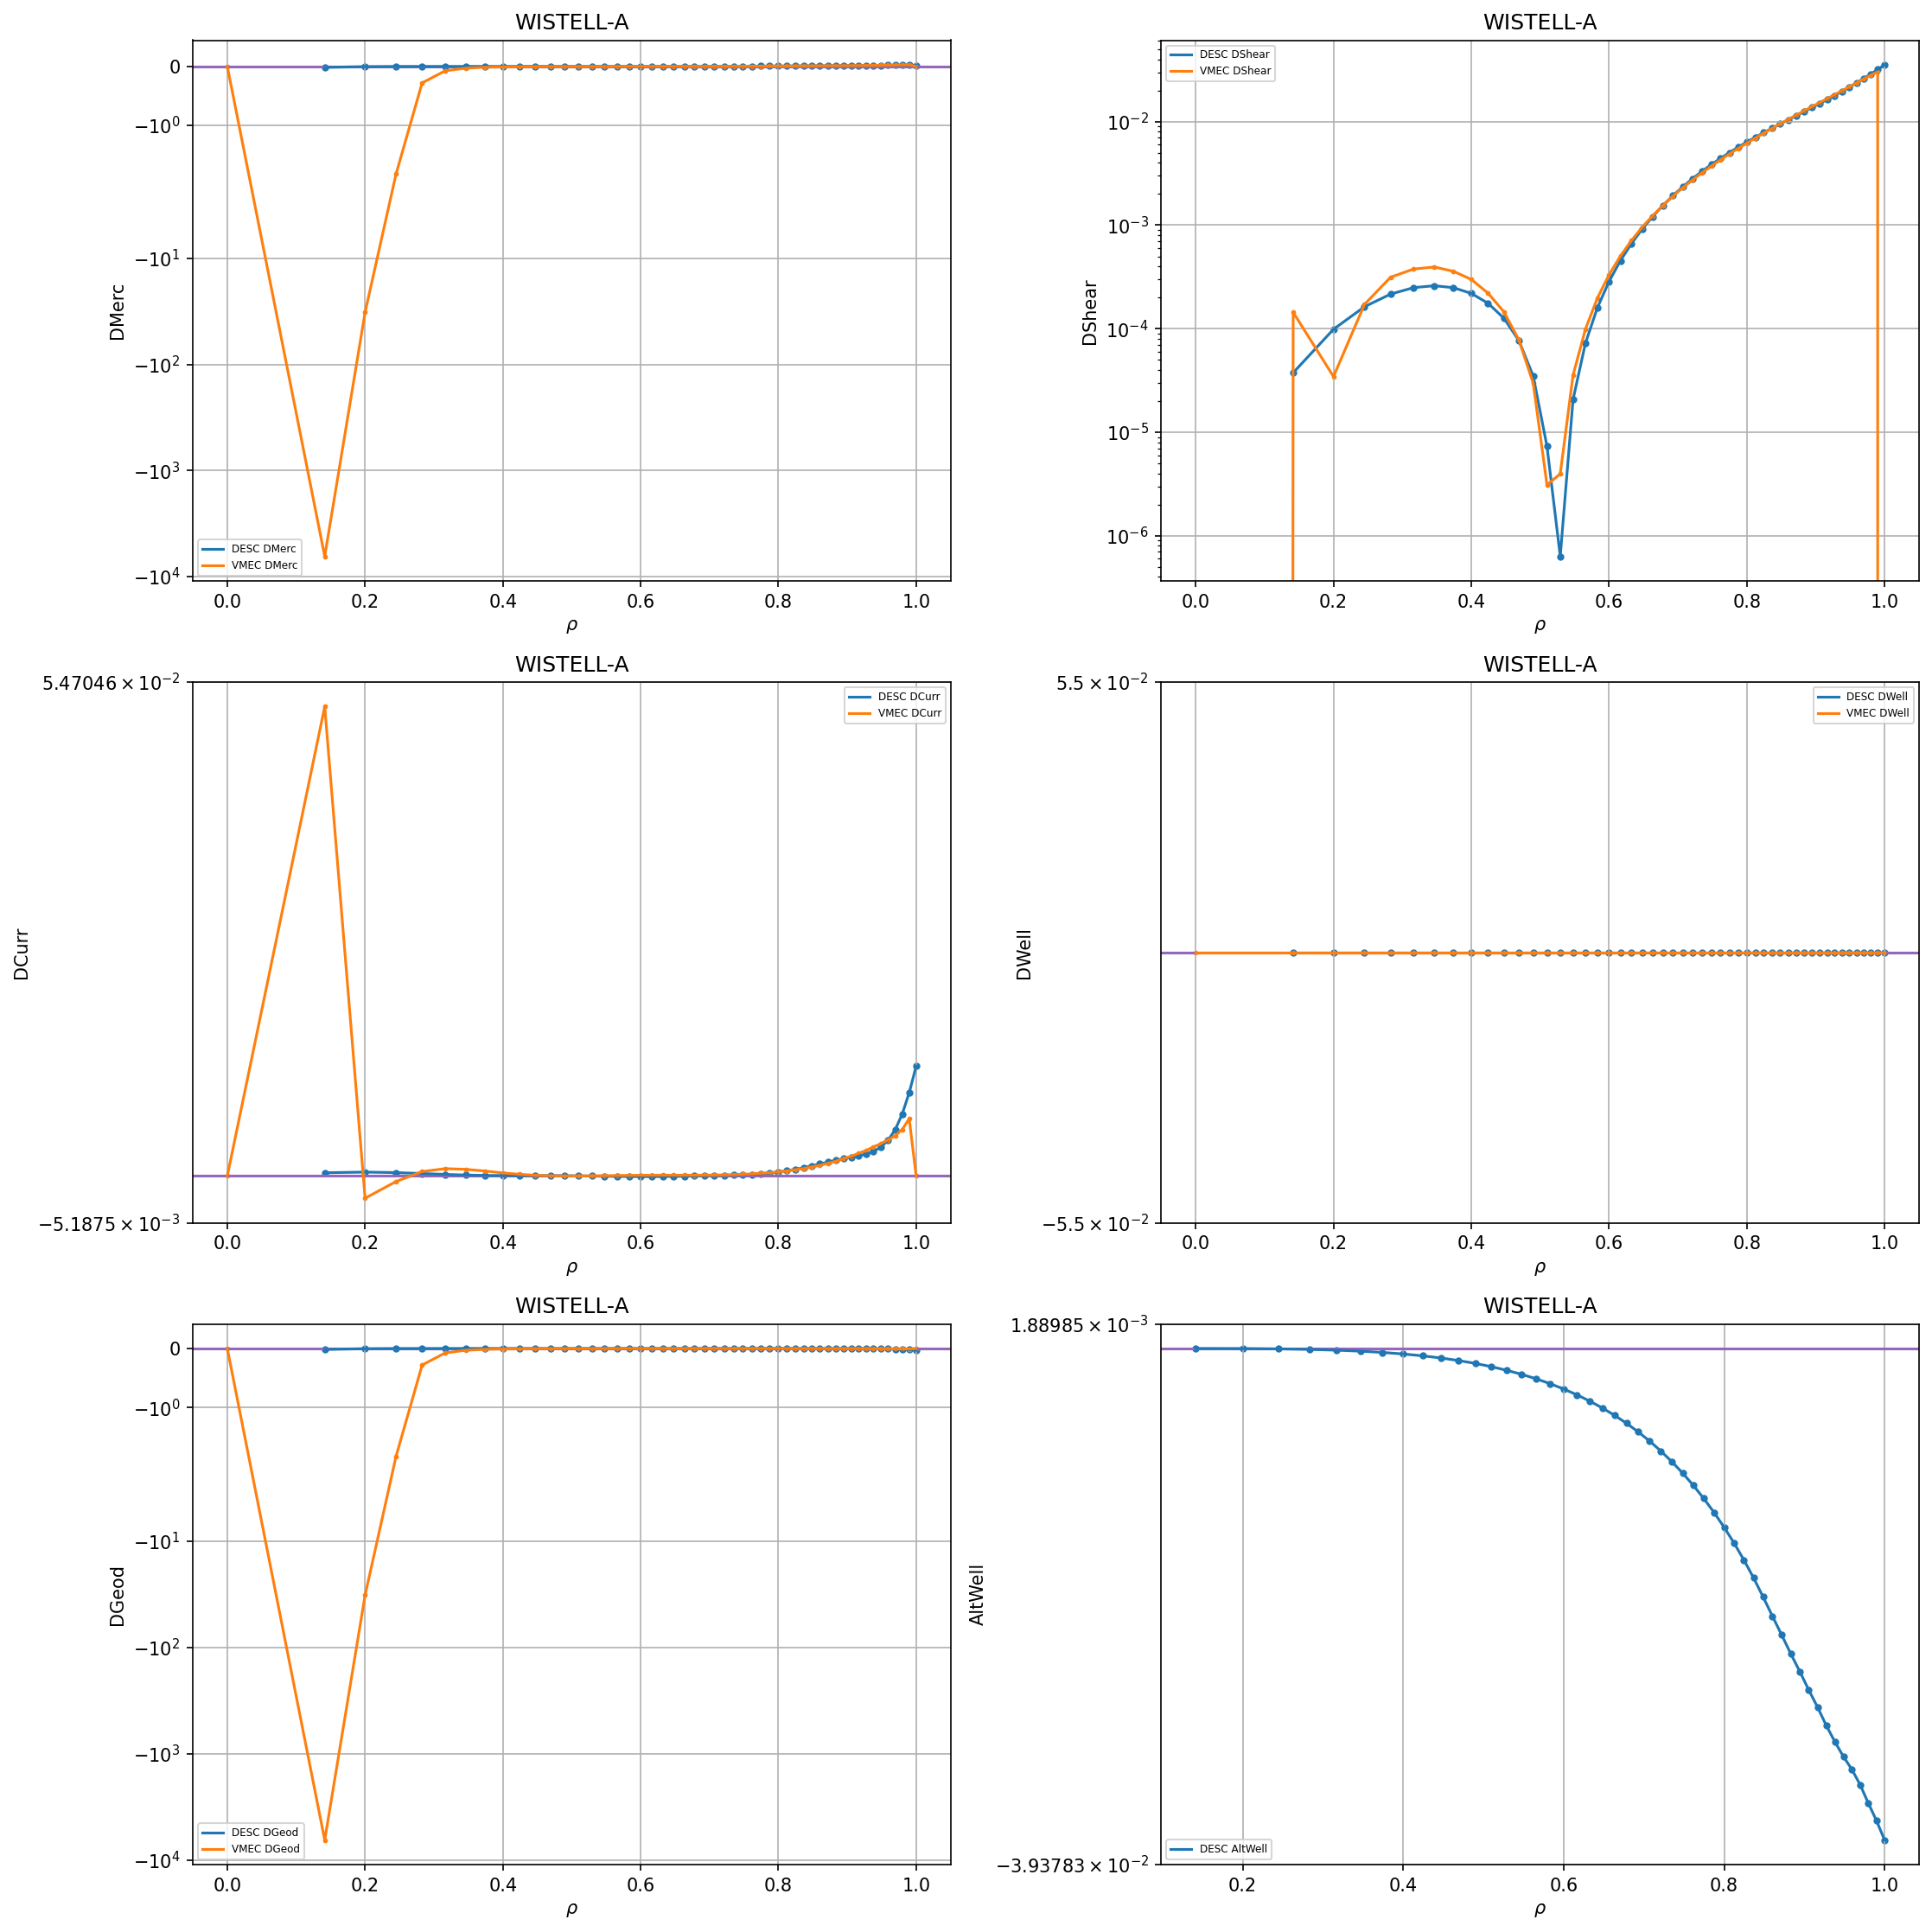

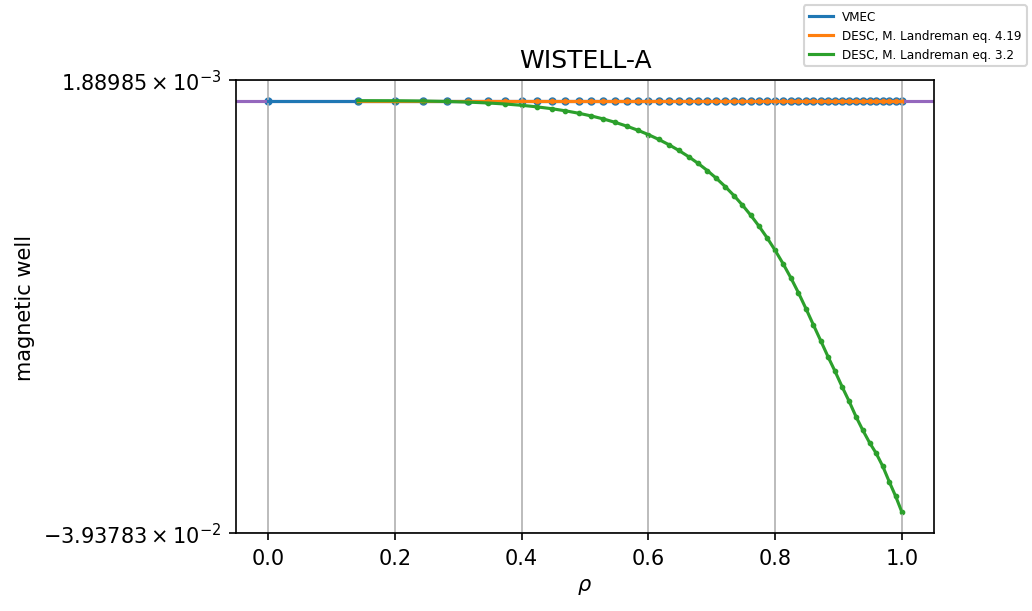

In [4]:
for s in stellarators:
    s.compute_plot()
    s.plot()
    s.plot_magnetic_wells()
    # s.save()

# Surface element computation problem and solution

Surface integral computations rely on the quantity d$\theta$ * d$\zeta$. This is obtained from splicing `grid.spacing`. The grid class takes advantage of things like reducing duplicated node weight, stellarator symmetry, and the number of field periods to reduce the amount of computation.

The problem is that, in the grid class's current implementation, the modifications made to `grid.spacing` to take advantage of symmetry and NFP do not preserve the value of d$\theta$ * d$\zeta$. So independently plucking out d$\theta$ * d$\zeta$ from a grid will not give the value its name implies.

Why is this? Because rescaling is done to preserve the full volume, or the weights (d$\rho$ * d$\theta$ * d$\zeta$) so that `grid.spacing.prod(axis=1).sum()` = 4$\pi$<sup>2</sup>, at the expense of changing d$\theta$ * d$\zeta$. Here's a visual:

In [5]:
# For any constant rho surface and NFP=1, grid.spacing is going
# to be an M*N length stack of the row vector (1, 2pi/M, 2pi/N).
g1 = LinearGrid(M=2, N=2, rho=np.array(1))
print(g1.spacing)
print()
# When NFP != 1, the values of drho are increased (decreased) while
# dtheta*dzeta decreases (increases).
# That's why the wrong volume was being computed for the heliotron with NFP > 1.
NFP = np.random.random_sample() * 100
print("NFP:", NFP)
g2 = LinearGrid(M=2, N=2, NFP=NFP, rho=np.array(1))
print(g2.spacing)

# the good thing is that the differential volume drho*dtheta*dzeta is preserved
# since that was the (main?) goal of the rescaling
assert np.allclose(g1.spacing.prod(axis=1), g2.spacing.prod(axis=1))
# and that, because rho=constant forces the drho vector to = 1 (with NFP=1),
# grid.weights is actually the value we expect from dtheta*dzeta (for any NFP).
if g1.num_rho == 1:
    assert np.allclose(g1.spacing.prod(axis=1), g1.spacing[:, 1:].prod(axis=1))
assert np.allclose(g1.spacing.prod(axis=1), g1.weights)  # definition of weights

[[1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]]

NFP: 56.94031541426061
[[1.         1.25663706 1.25663706]
 [1.         1.25663706 1.25663706]
 [1

## Solution

On grids which are defined completely by a single rho surface (`grid.num_rho = 1`), the correct volume will be computed $\forall NFP \in \mathbb{R}^{+}$, if we take d$\theta$ * d$\zeta$ to be `grid.weights` instead of `grid.spacing[:, 1:].prod(axis=1)`.

On grids which are defined over a range of rho surfaces (`grid.num_rho != 1`) this will not work because d$\rho$ != 1 on those grids. A general solution follows for computing the correct value for d$\theta$ * d$\zeta$ to other grids $g \in Grid : g.num\_rho \in \mathbb{N}$.
* Let $g1 \in Grid : g1.NFP = 1$ and $g2 \in Grid : g2.NFP \in \mathbb{R}^{+}$. Then given g2, d$\theta$ * d$\zeta$ = `g2.weights / g1.spacing[:, 0]`.
* I don't know how to retrieve g1.d$\rho$ from g2, other than storing it during grid construction.
* Until this can be fixed, any computation which requires differential surface elements (i.e. flux surface averages require the columns from `grid.spacing`) will yield incorrect quantities $\forall g \in Grid : g.num\_rho \in \mathbb{N} \setminus {1}\ and\ g.NFP \in \mathbb{R}^{+} \setminus {1}$.

The last source of error in the volume is the stellarator symmetry boolean. `enforce_symmetry()` again modifies d$\theta$ * d$\zeta$. Visual given below.

The error in computed volume that results from this is much smaller than the NFP error fixed above. The nodes with $\theta$ > $\pi$ are removed and so too are the spacings in the grid that correspond to those nodes. Now because `grid.spacing` is missing these nodes, to preserve the overall volume in ($\rho$, $\theta$, $\zeta$) space (`grid.weights.sum()`), the differential volume d$\rho$ * d$\theta$ * d$\zeta$ of the remaining spaces is increased so that the sum is still 4$\pi$<sup>2</sup>. This makes sense since we do want to increase the weight of the nodes 0 to $\pi$ to double count for the removed nodes. This process has preserving the volume d$\rho$ * d$\theta$ * d$\zeta$ in mind. It's not clear to me if a different scale factor (other than 4$\pi$<sup>2</sup>) would be better to preserve an area element d$\theta$ * d$\zeta$. Might be dependent on $\rho$.

In [6]:
g3 = LinearGrid(M=2, N=2, sym=True, rho=np.array(1))
print(g3.spacing)

[[1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]
 [1.         2.0943951  1.25663706]]


## Grid bug status as of Aug 7

With the new updates to the grid class and my NFP bug fix,
* correct computations result on these grids
    - $\forall g \in Grid : g.num\_rho \in \mathbb{1}\ and\ g.NFP \in \mathbb{R}^{+}\ and\ g.sym \in \mathbb{True, False}$.
* incorrect computations result on these grids
    - $\forall g \in Grid : g.num\_rho \in \mathbb{N} \setminus {1}\ and\ g.NFP \in \mathbb{R}^{+} \setminus {1}$.
    - $\forall g \in Grid : g.num\_rho \in \mathbb{N} \setminus {1}\ and\ g.NFP \in \mathbb{1}\ and\ g.sym \in \mathbb{True}$.